In [ ]:
!pip install transformers datasets tqdm torchinfo

In [97]:
import torch 
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoTokenizer
from datasets import load_dataset
from torchinfo import summary

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

In [98]:
df_ = pd.read_csv('cleaned-text-version-5.csv')

In [99]:
df = df_[['text', 'label']].copy()

In [ ]:
df.head()

,text,label
0,نماینده مجلس خطاب به قربانی اسیدپاشی ازدست مجر...,0
1,آرره دیگه بعدش گفتم استاد دارید مسخره میکنید م...,1
2,چجوری میتونی اصفهانی باشی و هوادار پرسپولیس چج...,1
3,داداش ت کی تموم میشه ایشالا چیزی نمونده پس بای...,0
4,در گذشته زندگی می کنی یا حال اگر در گذشته زندگ...,1


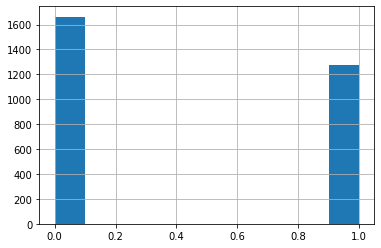

In [ ]:
df['label'].hist()

In [100]:
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42, shuffle=True)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=True)

In [101]:
df1 = train_data[['text', 'label']]
df1.columns = ['sentence', 'label']
df1.to_csv('train_data.csv', index=None)

In [102]:
df2 = val_data[['text', 'label']]
df2.columns = ['sentence', 'label']
df2.to_csv('val_data.csv', index=None)

In [103]:
df3 = test_data[['text', 'label']]
df3.columns = ['sentence', 'label']
df3.to_csv('test_data.csv', index=None)

In [ ]:
raw_dataset = load_dataset('csv', data_files={'train':'train_data.csv', 
                                              'validation': 'val_data.csv',
                                              'test': 'test_data.csv'
                                              })

In [105]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2205
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 368
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 368
    })
})

In [106]:
checkpoint = 'HooshvareLab/bert-fa-zwnj-base'
checkpoint_sentiment = 'HooshvareLab/bert-fa-base-uncased-sentiment-deepsentipers-multi'
checkpoint_sentiment_binary = 'HooshvareLab/bert-fa-base-uncased-sentiment-deepsentipers-binary'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [116]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True, max_length=64, padding='max_length')

In [ ]:
tokenized_datasets = raw_dataset.map(tokenize_fn, batched=True)

In [118]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig

In [119]:
config = AutoConfig.from_pretrained(checkpoint)

In [ ]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [ ]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [120]:
target_map = {'negative': 0, 'positive': 1}
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [121]:
config.num_labels = 2

In [ ]:
config

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

In [125]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              32,256,000
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 11

In [126]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    )

In [127]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [128]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
!ls training_dir

checkpoint-138	checkpoint-276	checkpoint-414	runs


In [ ]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-276',
                      device=0)

In [143]:
test_prediction = savedmodel(raw_dataset['test']['sentence'])

In [145]:
test_prob = [d['score'] if d['label'].startswith('p') else 1 - d['score'] for d in test_prediction]

In [146]:
def get_label(d):
  return 1 if d['label'] == 'positive' else 0

test_pred = [get_label(d) for d in test_prediction]

In [ ]:
for i in range(len(test_pred)):
  if raw_dataset['test']['label'][i] == 1:
    print(raw_dataset['test']['sentence'][i] , test_pred[i], raw_dataset['test']['label'][i])

In [133]:
print('acc:' , accuracy_score(raw_dataset['test']['label'], test_pred))

acc: 0.7255434782608695


In [140]:
print('f1:' , f1_score(raw_dataset['test']['label'], test_pred, average='macro'))

f1: 0.7187970493663703


In [135]:
def plot_cm(cm):
  classes = ['negative','positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Target')

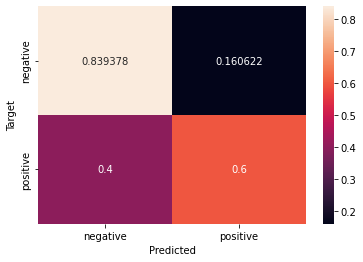

In [136]:
cm = confusion_matrix(raw_dataset['test']['label'], test_pred, normalize='true')
plot_cm(cm)

In [147]:
print('roc' , roc_auc_score(raw_dataset['test']['label'], test_prob))

roc 0.7598815692079941


In [142]:
print('f1:' , f1_score(1 - df3['label'], 1 - np.array(test_pred), average='macro'))

f1: 0.7187970493663703
